In [1]:
# run in scikit_env

import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

print(pd.__version__)

1.4.2


In [2]:
def get_bodies_data():    
    
    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}df_od_coordinates.pkl', 'rb') as file:
        bodies_df = pickle.load(file)

    # correcting that one in manhatten
    bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude'] = bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude_p']
    bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'longitude'] = bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude_p']

    # correcting those with wrong time stamp
    bodies_df.loc[bodies_df['date created'] == '00000000', 'date created'] = np.nan

    # create ythe date time date
    bodies_df['date'] = pd.to_datetime(bodies_df['date created'], format='%Y%m%d', exact = False)

    # Create location annotation dummy
    annotation_mask = (bodies_df['longitude'].notna()) & (bodies_df['latitude'].notna())
    bodies_df['location_annot'] = annotation_mask * 1 

    return(bodies_df)

In [3]:
def compile_bodies_df_ll(bodies_df):

    annotated = bodies_df.loc[bodies_df['location_annot'] == 1,'date'].values.reshape(-1, 1)
    annotated_location = bodies_df.loc[bodies_df['location_annot'] == 1, ['longitude', 'latitude']]

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(annotated)

    non_annotated = bodies_df.loc[bodies_df['location_annot'] == 0,'date'].values.reshape(-1, 1)
    non_annotated_img_id = bodies_df.loc[bodies_df['location_annot'] == 0,'img_id'] # to merge back

    distance, preds = neigh.kneighbors(non_annotated)
    distance_days = pd.to_timedelta(distance.reshape(-1,)) # from nano seconds to days

    non_annotated_df = pd.DataFrame({'img_id' : non_annotated_img_id, 'distance_days' : distance_days, 'pred_idx' : preds.reshape(-1,)})

    annotated_location['pred_idx'] = annotated_location.reset_index().index
    new_annotated_df = non_annotated_df.merge(right = annotated_location ,how='left', on= 'pred_idx')

    bodies_df_ll = bodies_df.merge(right = new_annotated_df, how = 'left', on = 'img_id')

    bodies_df_ll['longitude_full'] = bodies_df_ll.loc[:, 'longitude_x'].fillna(bodies_df_ll.loc[:, 'longitude_y'])
    bodies_df_ll.drop(['longitude_x', 'longitude_y'], axis=1, inplace=True)

    bodies_df_ll['latitude_full'] = bodies_df_ll.loc[:, 'latitude_x'].fillna(bodies_df_ll.loc[:, 'latitude_y'])
    bodies_df_ll.drop(['latitude_x', 'latitude_y'], axis=1, inplace=True)

    return(bodies_df_ll)

In [4]:
bodies_df = get_bodies_data()

In [5]:
# you need a dummy regarding wheter the location is infered.

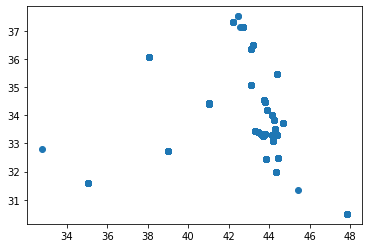

In [6]:
x = bodies_df[bodies_df['location_annot'] == 1]['longitude']
y = bodies_df[bodies_df['location_annot'] == 1]['latitude']

plt.scatter(x,y)
plt.show()

In [7]:
bodies_df_ll = compile_bodies_df_ll(bodies_df)

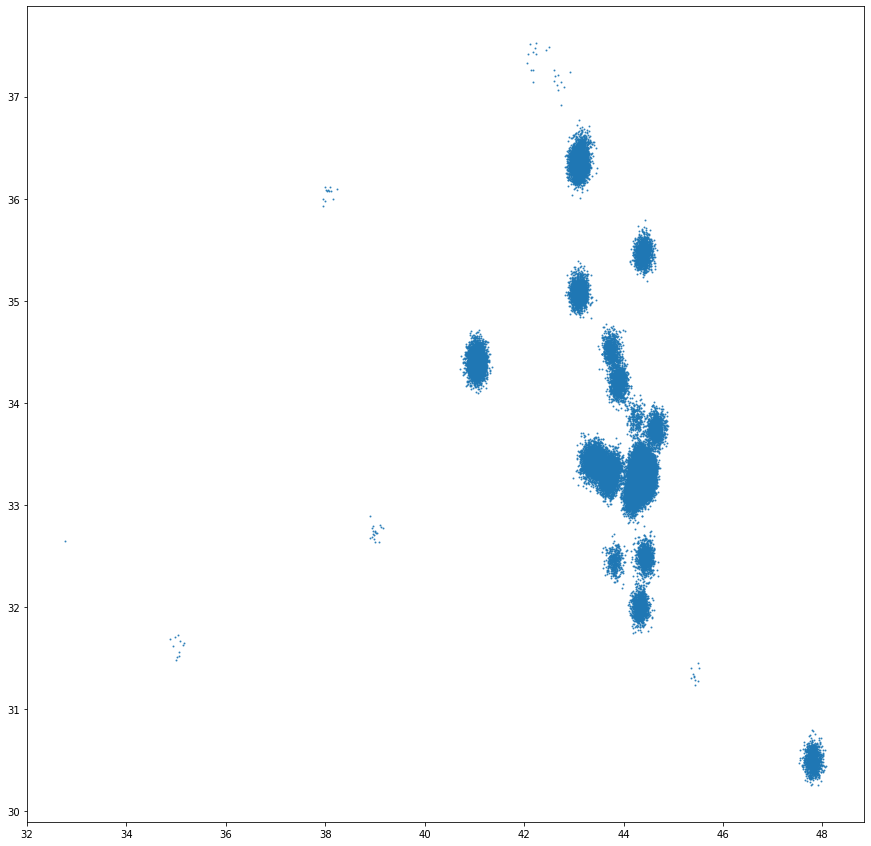

In [8]:
plt.figure(figsize= [15,15])

x = bodies_df_ll['longitude_full'] + np.random.randn(bodies_df_ll['longitude_full'].shape[0])/12 
y = bodies_df_ll['latitude_full'] + np.random.randn(bodies_df_ll['longitude_full'].shape[0])/12

plt.scatter(x,y, alpha = 0.8, s= 1)
plt.show()

In [9]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}df_od_coordinates_full.pkl', 'wb') as file:
    pickle.dump(bodies_df_ll, file)